# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.
Описание данных:

id — уникальный идентификатор скважины;

f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

product — объём запасов в скважине (тыс. баррелей).

Условия задачи:

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

### Библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
import os

### Анализ данных

In [2]:
data_files = ['geo_data_0.csv', 'geo_data_1.csv', 'geo_data_2.csv']
data = []

for file in data_files:
    file_path = os.path.join('/datasets', file)
    try:
        df = pd.read_csv(file_path)
        data.append(df)
    except FileNotFoundError:
        print(f"Файл {file_path} не найден.")

<div class="alert alert-info">
Подправил
</div>

'data[0]'

'Первые строчки:'

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


'Последние строчки:'

,id,f0,f1,f2,product
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764
99999,1CWhH,1.764754,-0.266417,5.722849,149.633246


'Случайные строчки:'

,id,f0,f1,f2,product
27454,fUwQ7,1.780053,0.045820,2.398640,90.381504
41991,JzebG,-0.900700,0.357580,2.569382,90.538567
25534,dqsRE,-1.023182,0.139706,7.351525,85.855893
8829,5nMas,0.065954,0.883238,-3.349864,19.706868
71717,gbJrL,1.339470,-0.586101,7.723748,182.597595


'Информация о каждом столбце:'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


'Общая информация:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


'Явные дубликаты:'

0

'Сортировка и количество пропущенных значений:'

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

'Гистограмма:'

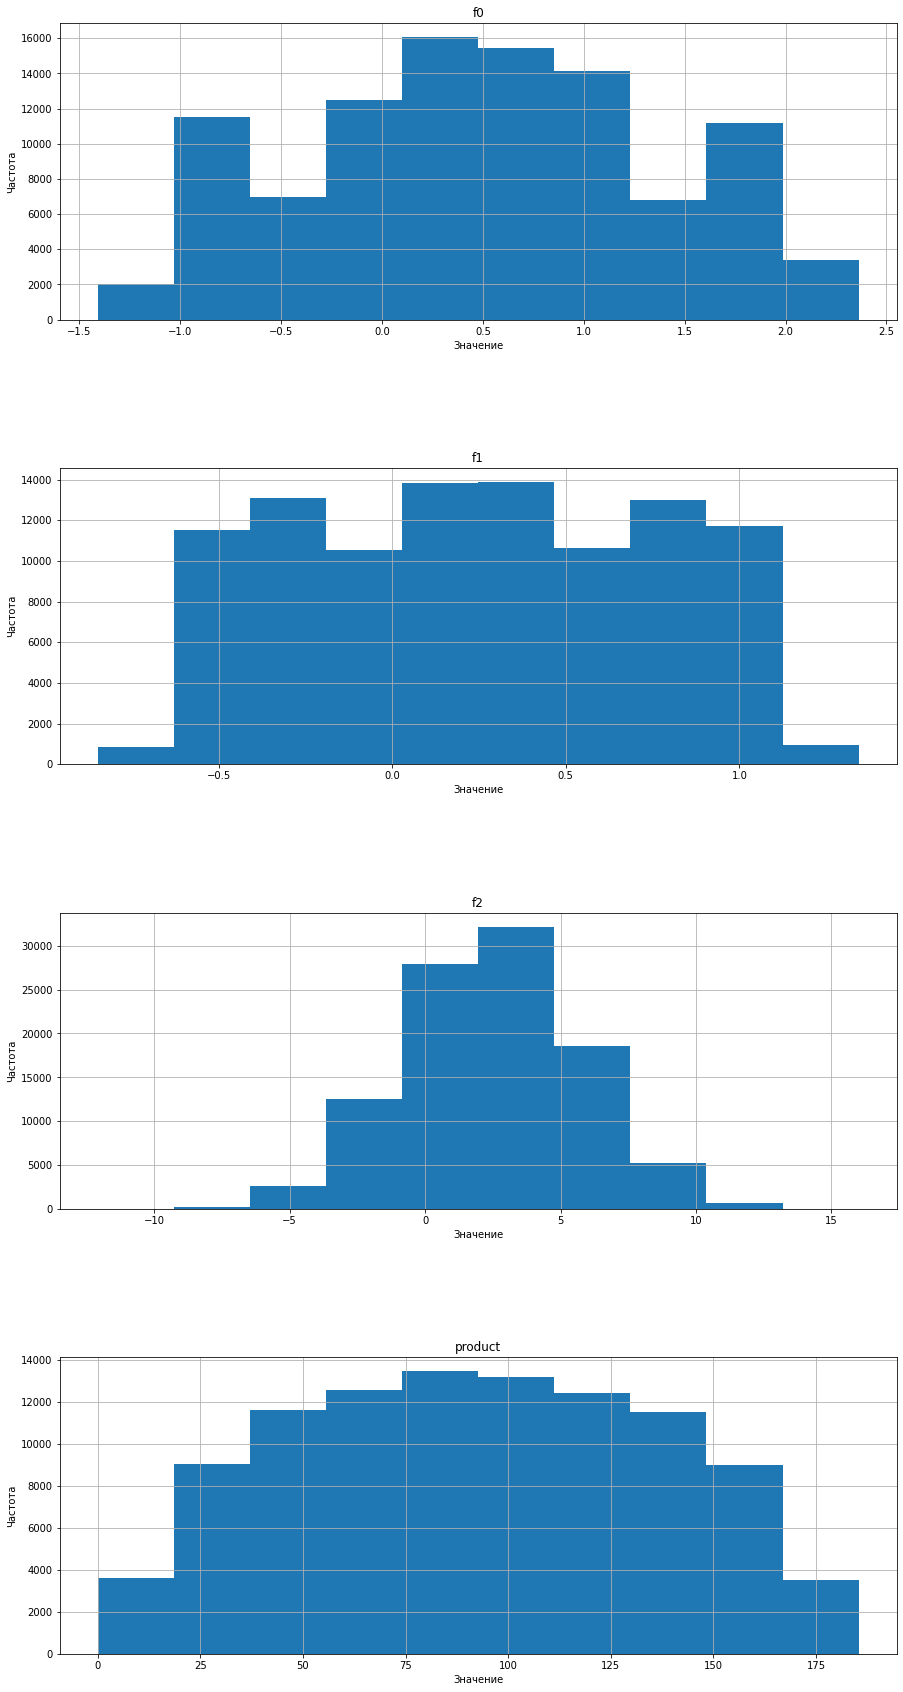

In [3]:
display("data[0]")
def analyze_dataframe(df):
    display("Первые строчки:", df.head())
    display("Последние строчки:", df.tail())
    display("Случайные строчки:", df.sample(5))
    display("Информация о каждом столбце:", df.describe())
    display("Общая информация:")
    df.info()
    display("Явные дубликаты:", df.duplicated().sum())
    display("Сортировка и количество пропущенных значений:", df.isnull().sum().sort_values())
    display("Гистограмма:")
    fig, axes = plt.subplots(nrows=4, figsize=(15, 30))
    df.hist(ax=axes, bins=10, column=df.columns[1:5])  # Используйте только столбцы 1, 2 и 3
    plt.subplots_adjust(hspace=0.5)
    for i, column in enumerate(df.columns[1:5]):
        axes[i].set_xlabel('Значение')
        axes[i].set_ylabel('Частота')
        axes[i].set_title(column)
    plt.show()
analyze_dataframe(data[0])

'data[1]'

'Первые строчки:'

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


'Последние строчки:'

,id,f0,f1,f2,product
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364
99999,relB0,-3.426139,-7.794274,-0.003299,3.179103


'Случайные строчки:'

,id,f0,f1,f2,product
81748,xNQhh,-16.028990,-3.180393,1.003378,30.132364
21757,MDX3n,-8.163209,-10.479218,2.996156,84.038886
15444,cMK1y,-6.139391,-16.878212,-0.000194,3.179103
17248,LYqug,20.631388,-2.690798,1.994687,53.906522
81058,bbien,10.678517,-7.775731,4.000275,107.813044


'Информация о каждом столбце:'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


'Общая информация:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


'Явные дубликаты:'

0

'Сортировка и количество пропущенных значений:'

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

'Гистограмма:'

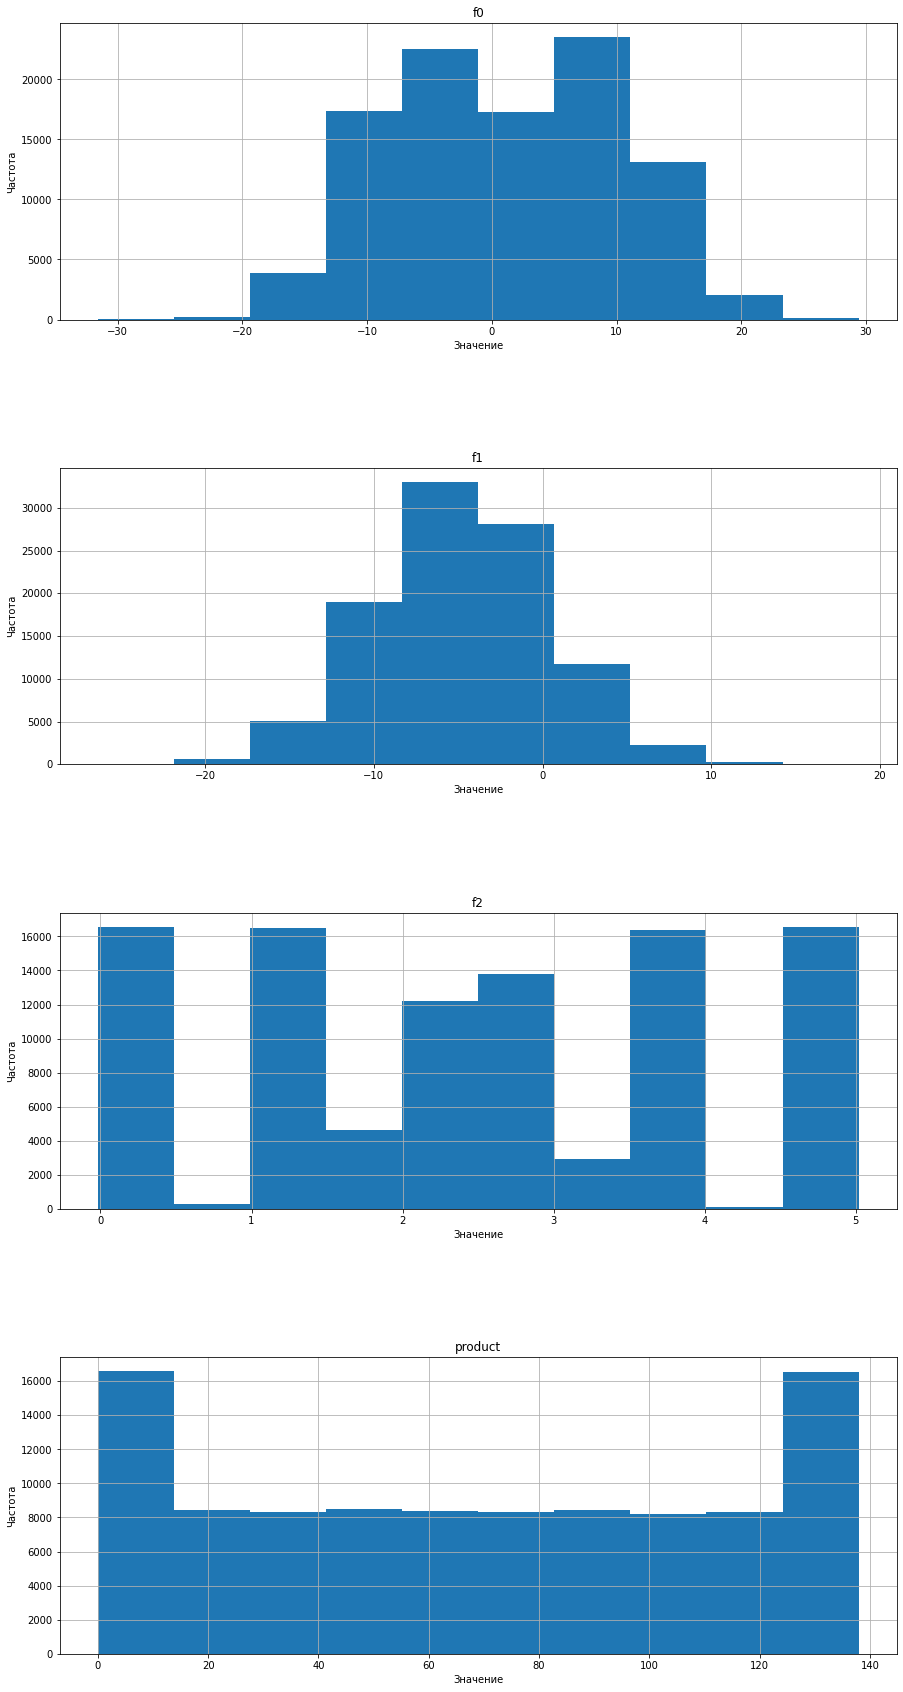

In [4]:
display("data[1]")
analyze_dataframe(data[1])

'data[2]'

'Первые строчки:'

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


'Последние строчки:'

,id,f0,f1,f2,product
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253
99999,V9kWn,-2.551421,-2.025625,6.090891,102.775767


'Случайные строчки:'

,id,f0,f1,f2,product
36121,5tWO3,-1.344997,1.848891,3.235122,92.305771
7682,Drauh,-1.822616,1.163887,3.164183,153.406195
33097,gWY57,-0.532835,0.777933,-3.244480,9.812654
68171,Bv63h,-0.138182,-0.351607,1.791254,97.172513
73745,yglQy,-0.939771,3.567393,4.756545,166.192581


'Информация о каждом столбце:'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


'Общая информация:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


'Явные дубликаты:'

0

'Сортировка и количество пропущенных значений:'

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

'Гистограмма:'

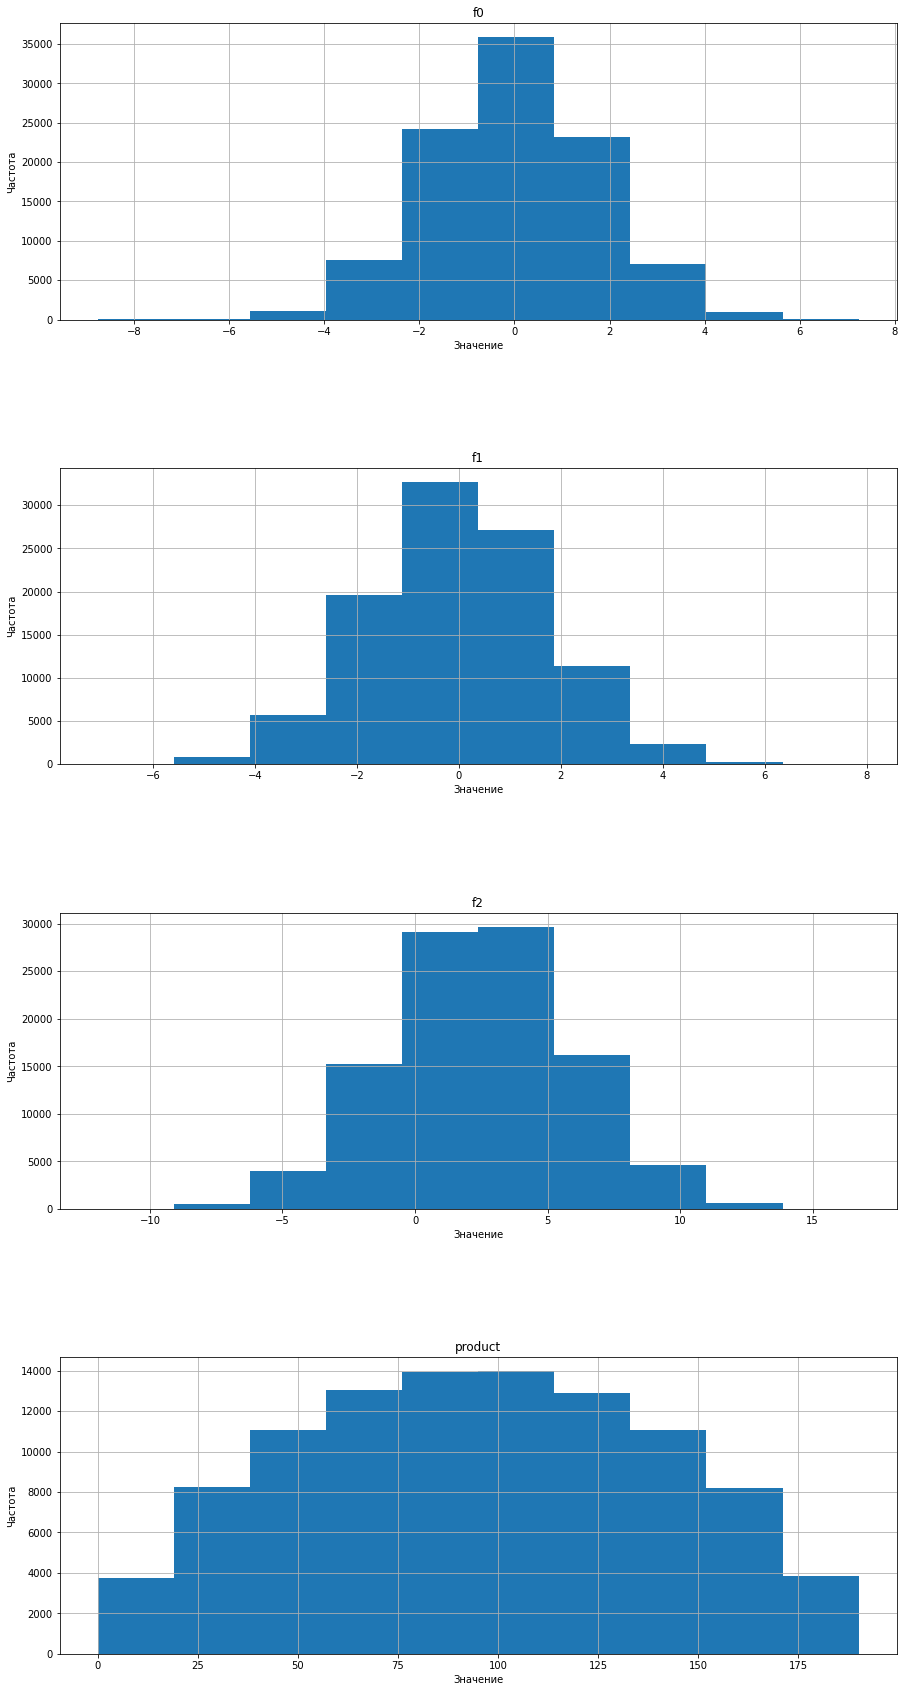

In [5]:
display("data[2]")
analyze_dataframe(data[2])

### Промежуточные выводы:

1. Последовательность столбцов логична
2. Явных дубликатов - нет
3. Столбец 'id' не принесёт пользы при обучении моделей, удалим
4. Значения и тип данных выглядят хорошо, масштабирование и изменение типа не потребуется

Удаляем столбец id

In [6]:
data[0] = data[0].drop('id', axis=1)
data[1] = data[1].drop('id', axis=1)
data[2] = data[2].drop('id', axis=1)

Данные подготовленны!

## Обучение и проверка модели

### Обучение модели

Напишем собственную функцию, которая:
1. Разбьёт данные на обучающую и валидационную выборки в соотношении 75:25.
2. Обучит модель и сделает предсказания на валидационной выборке.
3. Сохранит предсказание и правильные ответы на валидационной выборке.
4. Напечатает на экране средний запас предсказанного сырья и RMSE модели.

In [7]:
def train_and_evaluate_model(data):
    X = data.drop('product', axis=1)
    Y = data['product']
    X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.25, random_state=12345)

    model = LinearRegression()
    model.fit(X_train, Y_train)
    
    Y_pred = model.predict(X_valid)
    
    predictions = pd.Series(Y_pred, index=X_valid.index, name='predicted_product')
    results = pd.concat([predictions, Y_valid], axis=1)
    
    average_predicted_product = predictions.mean()
    rmse = mean_squared_error(Y_valid, Y_pred, squared=False)
    print("Средний запас предсказанного сырья:", average_predicted_product, "тыс.")
    print("RMSE модели:", rmse)
    #сохранение результатов
    return results

In [8]:
results_0 = train_and_evaluate_model(data[0])
results_1 = train_and_evaluate_model(data[1])
results_2 = train_and_evaluate_model(data[2])

Средний запас предсказанного сырья: 92.59256778438035 тыс.
RMSE модели: 37.5794217150813
Средний запас предсказанного сырья: 68.728546895446 тыс.
RMSE модели: 0.893099286775617
Средний запас предсказанного сырья: 94.96504596800489 тыс.
RMSE модели: 40.02970873393434


### Промежуточные выводы

1. Первый регион

    1) Средний запас предсказанного сырья составляет 92.59 тыс. баррелей.
    
    2) RMSE модели составляет 37.58, что означает, что среднеквадратичная ошибка предсказания модели составляет около 37.58 тыс. баррелей.
    
    3) Средний предсказанный запас сырья (92.59) близок к среднему значению (mean) запаса сырья (92.50).
    
    
2. Второй регион

    1) Средний запас предсказанного сырья составляет 68.73 тыс. баррелей.
    
    2) RMSE модели составляет 0.89, что означает, что модель дает точные предсказания с очень низкой среднеквадратичной ошибкой.
    
    3) Средний предсказанный запас сырья (68.73) близок к среднему значению (mean) запаса сырья (68.82).


3. Третий регион:

    1) Средний запас предсказанного сырья составляет 94.97 тыс. баррелей.
    
    2) RMSE модели составляет 40.03, что означает, что среднеквадратичная ошибка предсказания модели составляет около 40.03 тыс. баррелей.
    
    3) Средний предсказанный запас сырья (94.97) близок к среднему значению (mean) запаса сырья (95.00).

## Подготовка к расчёту прибыли

### Рассчёт достаточного объёма и сравнение

In [9]:
# Ключевые значения для расчетов
BUDGET = 10_000_000_000
REVENUE_PER_BARREL = 450_000
NUM_SAMPLES = 500
NUM_BEST_SAMPLES = 200

In [10]:
breakeven_volume = BUDGET / (REVENUE_PER_BARREL * NUM_BEST_SAMPLES)
print("Достаточный объем сырья для безубыточной разработки: {:.2f} тыс. баррелей".format(breakeven_volume))

Достаточный объем сырья для безубыточной разработки: 111.11 тыс. баррелей


In [11]:
def calculate_profitability(region_data):
    average_volume = region_data['product'].mean()
    profitability_check =  average_volume/breakeven_volume*100
    print("Средний запас сырья в регионе: {:.2f} тыс. баррелей".format(average_volume))
    print("Процент окупаемости разработки: {:.2f}%".format(profitability_check))

In [12]:
print("Регион 1")
calculate_profitability(data[0])
print("Регион 2")
calculate_profitability(data[1])
print("Регион 3")
calculate_profitability(data[2])

Регион 1
Средний запас сырья в регионе: 92.50 тыс. баррелей
Процент окупаемости разработки: 83.25%
Регион 2
Средний запас сырья в регионе: 68.83 тыс. баррелей
Процент окупаемости разработки: 61.94%
Регион 3
Средний запас сырья в регионе: 95.00 тыс. баррелей
Процент окупаемости разработки: 85.50%


### Промежуточные выводы:

1. Достаточный объем сырья для безубыточной разработки: 111.11 тыс. баррелей

    Регион 1
    Средний запас сырья в регионе: 92.50 тыс. баррелей
    Процент окупаемости разработки: 83.25%
    
    Регион 2
    Средний запас сырья в регионе: 68.83 тыс. баррелей
    Процент окупаемости разработки: 61.94%
    
    Регион 3
    Средний запас сырья в регионе: 95.00 тыс. баррелей
    Процент окупаемости разработки: 85.50%
    
    
    
2. Во всех регионах объём сырья меньше, чем объём, необходимый для безубыточной разработки

## Расчёт прибыли и рисков 

Функция расчёта прибыли

In [13]:
def calculate_profit(target, predictions, to_chose):
    sorted_predictions = predictions.sort_values(ascending=False)
    
    revenue = target[sorted_predictions.index][:to_chose].sum()
    
    return revenue * REVENUE_PER_BARREL - BUDGET

### Расчитаем прибыль и риски для каждого региона:

In [14]:
state = np.random.RandomState(12345)
def calculate_region_results(results):
    profits = []

    for i in range(1000):
        bootstrap_sample = results.sample(NUM_SAMPLES, replace=True, random_state=state)
        profit = calculate_profit(bootstrap_sample['product'], bootstrap_sample['predicted_product'], NUM_BEST_SAMPLES)
        profits.append(profit)
        
    mean_profit = np.mean(profits)
    confidence_interval = np.percentile(profits, [2.5, 97.5])
    loss_probability = np.mean(np.array(profits) < 0)
    print("Средняя прибыль:", mean_profit)
    print("Доверительный интервал (95%):", confidence_interval)
    print("Риск убытков:", loss_probability)

In [15]:
print("Результаты расчета рисков и прибыли для каждого региона:")
print("Регион 1:")
calculate_region_results(results_0)
print("Регион 2:")
calculate_region_results(results_1)
print("Регион 3:")
calculate_region_results(results_2)

Результаты расчета рисков и прибыли для каждого региона:
Регион 1:
Средняя прибыль: 425938526.91059244
Доверительный интервал (95%): [-1.02090095e+08  9.47976353e+08]
Риск убытков: 0.06
Регион 2:
Средняя прибыль: 518259493.6973249
Доверительный интервал (95%): [1.28123231e+08 9.53612982e+08]
Риск убытков: 0.003
Регион 3:
Средняя прибыль: 420194005.3440501
Доверительный интервал (95%): [-1.15852609e+08  9.89629940e+08]
Риск убытков: 0.062


### Вывод

С учетом полученных данных, регион 2 демонстрирует наилучшие результаты:

1. Он имеет самую высокую среднюю прибыль среди всех регионов.

2. Доверительный интервал для региона 2 также шире, что указывает на большую стабильность прибыли.

3. Риск убытков для региона 2 составляет всего 0.003 (0.3%), что говорит о малой вероятности убытков.


На основе этих данных, рекомендуется выбрать регион 2 для разработки скважин, так как он показывает наилучшие результаты с точки зрения прибыли и рисков.